In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import pandas as pd
from scipy import stats
from sklearn import metrics
from os.path import dirname, join as pjoin
from sklearn.ensemble import IsolationForest
from sklearn.ensemble._iforest import _average_path_length 
import seaborn as sns



def get_data(name,aux = ''):
    
    print('\n')
    # fix the data directory before starting
    filename = pjoin(aux,name)
    print(name)
    
    # load data stored in .mat files
    mat_contents = sio.loadmat(filename)

    X,y = mat_contents['X'],mat_contents['y']
    
    # dataset statistics
    n_data        = X.shape[0]
    n_features    = X.shape[1]
    n_anomalies   = sum(y.flatten())
    contamination = n_anomalies/n_data * 100
    
    return X,y

def measure(y_true, y_pred, plot = False):

    # apply metrics
    fpr, tpr, thresholds          = metrics.roc_curve(y_true, y_pred)
    auc                           = metrics.auc(fpr, tpr)
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    average_precision_score       = metrics.average_precision_score(y_true, y_pred)

    if plot == True:
        plot_prc(fpr, tpr,auc,recall,precision,average_precision_score) 
    else: 
        return average_precision_score

def plot_prc(fpr, tpr,auc,recall,precision,average_precision_score):

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=[5*2,5])

    def ax_plot(ax,x,y,xlabel,ylabel,title=''):
        ax.plot(x,y);ax.set_xlabel(xlabel),;ax.set_ylabel(ylabel)
        ax.set_title(title);ax.grid()

    ax_plot(ax1,fpr, tpr,'fpr', 'tpr',title="auc: {:.3f}".format(auc))
    ax_plot(ax2,recall,precision, 'recall','precision', title="average precision: {:.3f}".format(average_precision_score))

# IF on Diet
To get the tree depths for each sample point, we used a modified version of the original _sklearn_ function, that can be found here:
- https://github.com/scikit-learn/scikit-learn/blob/844b4be24/sklearn/ensemble/_iforest.py#L26

In [15]:
def compute_tree_anomaly_scores(forest,X):
    """
    Compute the score of each samples in X going through the extra trees.
    Parameters
    ----------
    X : array-like or sparse matrix
        Data matrix.
    subsample_features : bool
        Whether features should be subsampled.
    """
    n_samples = X.shape[0]

    depths = np.zeros(n_samples, order="f")

    collection_tree_anomaly_scores = []

    for tree in forest.estimators_:

        leaves_index   = tree.apply(X)
        node_indicator = tree.decision_path(X)
        n_samples_leaf = tree.tree_.n_node_samples[leaves_index]

        tree_anomaly_scores = (
            np.ravel(node_indicator.sum(axis=1))
            + _average_path_length(n_samples_leaf)
            - 1.0)

        depths += tree_anomaly_scores


        collection_tree_anomaly_scores.append(tree_anomaly_scores)


    denominator = len(forest.estimators_) * _average_path_length([forest.max_samples_])
    scores = 2 ** (
        # For a single training sample, denominator and depth are 0.
        # Therefore, we set the score manually to 1.
        -np.divide(
            depths, denominator, out=np.ones_like(depths), where=denominator != 0
        )
    )
    return scores,np.array(collection_tree_anomaly_scores)

def study(data_train,labels_train,name):
    
    n_repetitions = 100
    
    sk_IF = train_test_measure(data_train,labels_train)
    
    ap_tree_train,tree_train = get_tree_collections(sk_IF,data_train,labels_train)
    
    plt.figure()
    _ = plt.hist(ap_tree_train)
    plt.title('histogram of the tree average precison');plt.grid(True)

    best  = get_forests('best',labels_train,ap_tree_train,tree_train)
    worst = get_forests('worst',labels_train,ap_tree_train,tree_train)
    mean_random,std_random = get_random_forests(labels_train,n_repetitions,ap_tree_train,tree_train)
    
    plt.figure()
    plt.plot(best,label='best')
    plt.plot(worst,label='worst')
    plt.xlabel("forest composed of $n$ trees");plt.ylabel("average precision score")
    
    x = np.hstack([np.arange(100),np.arange(100)[::-1]])
    y = np.hstack([mean_random+std_random,(mean_random-std_random)[::-1]])
    plt.plot(mean_random,color='green',linestyle='--',label='random')
    plt.fill(x,y,color='green',alpha=0.1)
    
    plt.grid(True);plt.legend()


    plt.hlines(best[0],0,100,color='k',linestyle='--',linewidth=1)
    plt.hlines(best[-1],0,100,color='k',linestyle='--',linewidth=1)
    plt.hlines(best.max(),0,100,color='k',linestyle='--',linewidth=1)
    plt.hlines(worst[0],0,100,color='k',linestyle='--',linewidth=1)
    plt.hlines(worst.min(),0,100,color='k',linestyle='--',linewidth=1)
    
    plt.title(name)
    plt.savefig(name)
    plt.show()
    
    

def train_test_measure(data,labels,plot=True):
    
    sk_IF = IsolationForest(random_state=0).fit(data)
    y_pred      = sk_IF.score_samples(data)

    measure(labels,  -y_pred, plot=plot)
    
    return sk_IF

def get_tree_collections(sk_IF,data,labels):

    sklean_scores,collection_tree_anomaly_scores = compute_tree_anomaly_scores(sk_IF,data)
    
    collection_tree_average_precision = []
    for tree_anomaly_scores in collection_tree_anomaly_scores:
        tree_average_precision = measure(labels, - tree_anomaly_scores) ## MINUS SIGN
        collection_tree_average_precision.append(tree_average_precision)
    collection_tree_average_precision = np.array(collection_tree_average_precision)
    
    return collection_tree_average_precision,collection_tree_anomaly_scores

def get_forests(strategy,labels,collection_tree_average_precision,collection_tree_anomaly_scores):

    # WORST
    if strategy == 'best':
        order = -1
    elif strategy == 'worst':
        order = 1
        
    argsort_collection_tree_average_precision = np.argsort(collection_tree_average_precision)[::order]

    sorted_collection_tree_anomaly_scores = collection_tree_anomaly_scores[argsort_collection_tree_average_precision]

    collection_forest_anomaly_scores = (sorted_collection_tree_anomaly_scores.cumsum(axis=0).T/np.arange(1,sorted_collection_tree_anomaly_scores.shape[0]+1)).T
    
    collection_forest_average_precision = []
    for forest_anomaly_scores in collection_forest_anomaly_scores:
        forest_average_precision = measure(labels, - forest_anomaly_scores) ## MINUS SIGN
        collection_forest_average_precision.append(forest_average_precision)
    collection_forest_average_precision = np.array(collection_forest_average_precision)
    
    return collection_forest_average_precision

def get_random_forests(labels,n_repetitions,collection_tree_average_precision,collection_tree_anomaly_scores):

    repetitions_collection_forest_average_precision = []
    for r in range(n_repetitions):
        print("\r random repetition {:.0f}".format(r),end='')

        argsort_collection_tree_average_precision = np.random.choice(np.arange(collection_tree_average_precision.shape[0]),collection_tree_average_precision.shape[0],replace=False)

        sorted_collection_tree_anomaly_scores = collection_tree_anomaly_scores[argsort_collection_tree_average_precision]

        collection_forest_anomaly_scores = (sorted_collection_tree_anomaly_scores.cumsum(axis=0).T/np.arange(1,sorted_collection_tree_anomaly_scores.shape[0]+1)).T

        collection_forest_average_precision = []
        for forest_anomaly_scores in collection_forest_anomaly_scores:
            forest_average_precision = measure(labels, - forest_anomaly_scores) ## MINUS SIGN
            collection_forest_average_precision.append(forest_average_precision)
        collection_forest_average_precision = np.array(collection_forest_average_precision)

        repetitions_collection_forest_average_precision.append(collection_forest_average_precision)
    repetitions_collection_forest_average_precision = np.array(repetitions_collection_forest_average_precision)

    mean_random = repetitions_collection_forest_average_precision.mean(axis=0)
    std_random  = repetitions_collection_forest_average_precision.std(axis=0)
    
    return mean_random,std_random

In [5]:
!pwd

/Users/Tommaso/Documents/PythonCode/IsolationForest/sklearn-based/IFonaDiet




annthyroid.mat
 random repetition 99

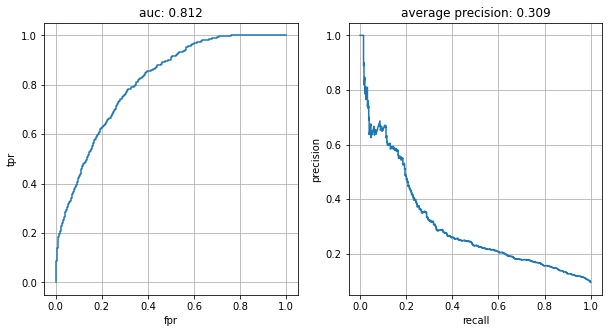

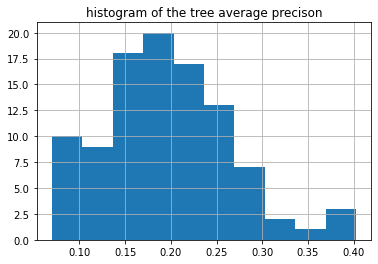

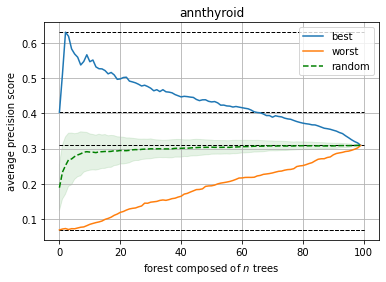



arrhythmia.mat
 random repetition 99

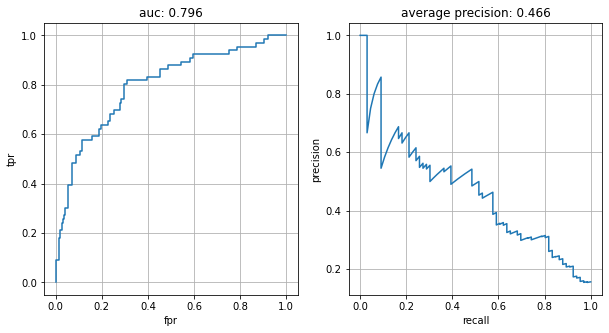

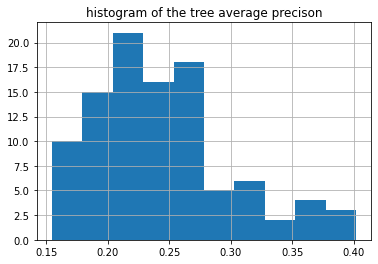

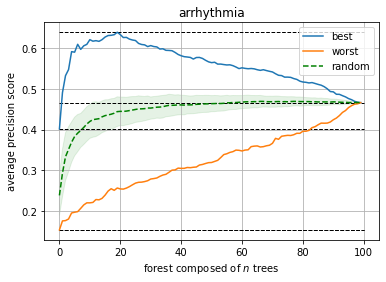



breastw.mat
 random repetition 99

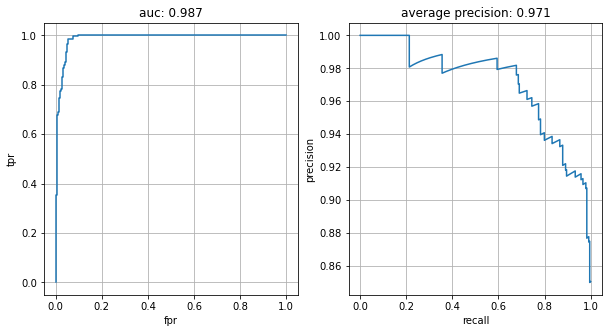

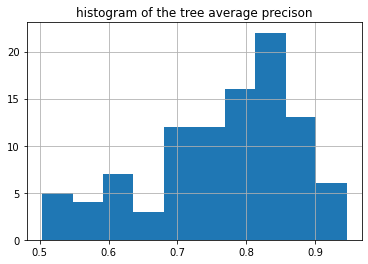

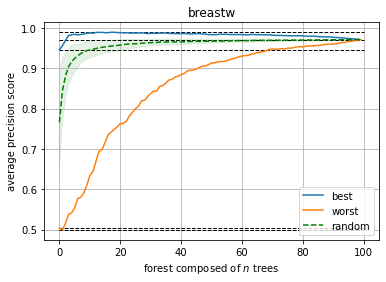



cardio.mat
 random repetition 99

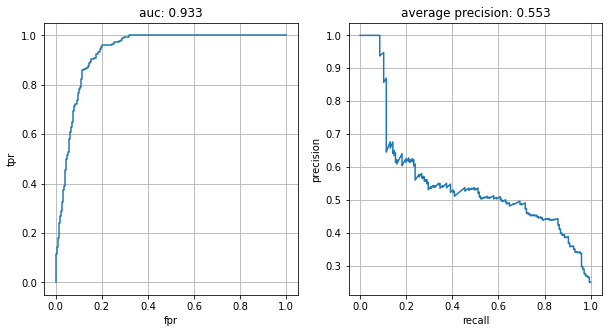

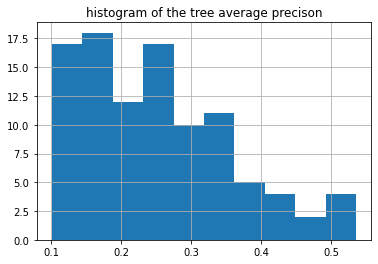

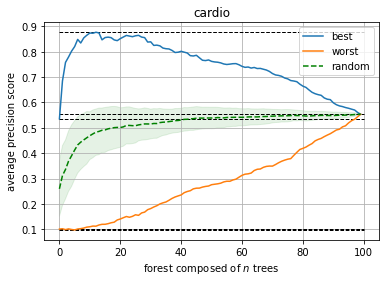



cover.mat
 random repetition 25cover.mat


ecoli.mat
ecoli.mat


glass.mat
 random repetition 46glass.mat


http.mat
http.mat


ionosphere.mat
 random repetition 13

In [7]:
import glob
import os

aux = '/Users/Tommaso/Documents/PythonCode/Datasets/data/'

for filename in np.sort(glob.glob("/Users/Tommaso/Documents/PythonCode/Datasets/data/*.mat")):
    name = os.path.basename(filename)
    
    try:
        data,labels = get_data(name,aux)
        study(data,labels,name[:-4])
    except:
        print(name)

# Paper plot

In [16]:
def paper_plot(ax,data_train,labels_train,name,n_repetitions = 100):
    
    sk_IF = train_test_measure(data_train,labels_train,plot=False)
    
    ap_tree_train,tree_train = get_tree_collections(sk_IF,data_train,labels_train)
    
    #plt.figure()
    #_ = plt.hist(ap_tree_train)
    #plt.title('histogram of the tree average precison');plt.grid(True)

    best  = get_forests('best',labels_train,ap_tree_train,tree_train)
    worst = get_forests('worst',labels_train,ap_tree_train,tree_train)
    mean_random,std_random = get_random_forests(labels_train,n_repetitions,ap_tree_train,tree_train)
    
    #plt.figure()
    ax.plot(best,label='best')
    ax.plot(worst,label='worst')
    ax.set_xlabel("forest composed of $n$ trees");ax.set_ylabel("average precision score")
    
    x = np.hstack([np.arange(100),np.arange(100)[::-1]])
    y = np.hstack([mean_random+std_random,(mean_random-std_random)[::-1]])
    ax.plot(mean_random,color='green',linestyle='--',label='random')
    ax.fill(x,y,color='green',alpha=0.1)
    
    ax.grid(True)#;ax.legend()


    ax.hlines(best[0],0,100,color='k',linestyle='--',linewidth=1)
    ax.hlines(best[-1],0,100,color='k',linestyle='--',linewidth=1)
    ax.hlines(best.max(),0,100,color='k',linestyle='--',linewidth=1)
    ax.hlines(worst[0],0,100,color='k',linestyle='--',linewidth=1)
    ax.hlines(worst.min(),0,100,color='k',linestyle='--',linewidth=1)
    
    ax.set_title(name)



annthyroid
 random repetition 99

arrhythmia
 random repetition 99

breastw
 random repetition 99

cardio
 random repetition 99

cover
 random repetition 99

ionosphere
 random repetition 99

letter
 random repetition 99

mammography
 random repetition 99

mnist
 random repetition 99

musk
 random repetition 99

optdigits
 random repetition 99

pendigits
 random repetition 99

pima
 random repetition 99

satellite
 random repetition 99

satimage-2
 random repetition 99

shuttle
 random repetition 99

speech
 random repetition 99

thyroid
 random repetition 99

vertebral
 random repetition 99

vowels
 random repetition 99

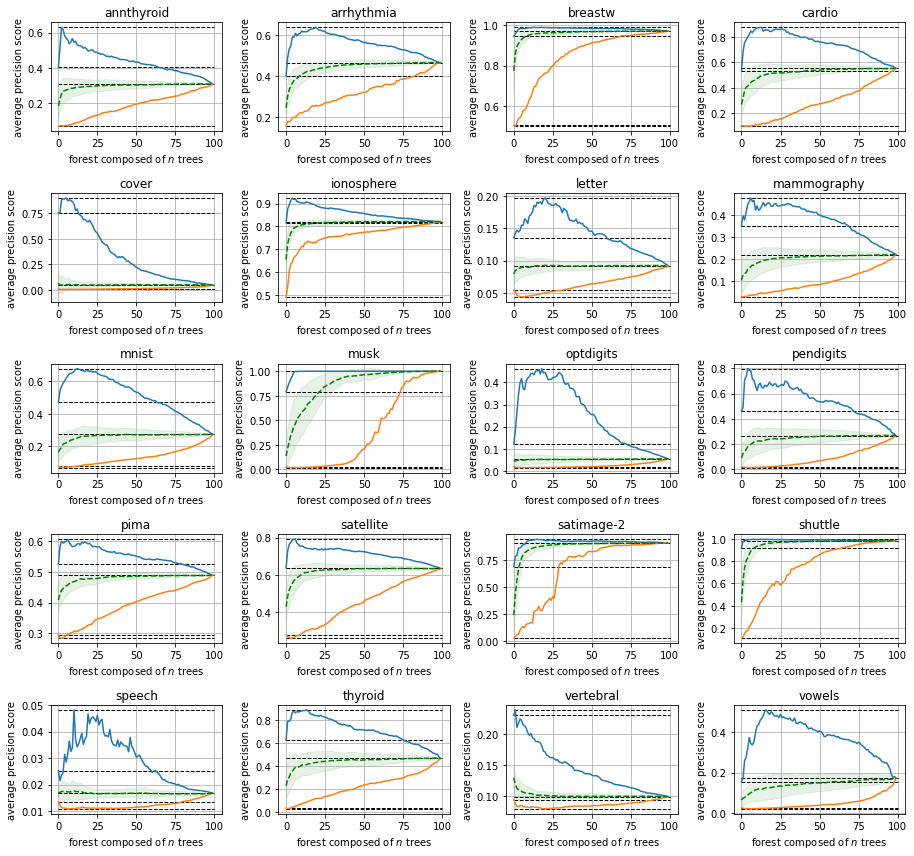

In [18]:
import glob,os

aux = '/Users/Tommaso/Documents/PythonCode/Datasets/data/'

fig,axs = plt.subplots(5,4,figsize=[6.4/2*4,4.8/2*5])
axs = axs.flatten()

for i,name in enumerate(['annthyroid', 'arrhythmia', 'breastw' ,'cardio' ,'cover', 'ionosphere',
 'letter', 'mammography', 'mnist' ,'musk' ,'optdigits' ,'pendigits', 'pima',
 'satellite', 'satimage-2' ,'shuttle' ,'speech' ,'thyroid', 'vertebral',
 'vowels']):
    #name = os.path.basename(filename)
    
    #try:
    data,labels = get_data(name,aux)
    paper_plot(axs[i],data,labels,name,n_repetitions=100)
    #except:
    #    print(name)
    plt.tight_layout()